# Paired Parlay Strategy V1 (Not that good)
- This strategy is meant to try and find +EV parlay pairs using dependent stats on a single player
- TODO: Implement a etter lines approximation, currently just a running mean weighted towards the latest result (historical approximation)

In [1]:
import nflreadpy as nfl

In [7]:
data = nfl.load_player_stats(True,"week")

Downloading: 100%|██████████| 592k/592k [00:00<00:00, 64.6MB/s]


Downloading: 100%|██████████| 579k/579k [00:00<00:00, 45.6MB/s]


Downloading: 100%|██████████| 585k/585k [00:00<00:00, 66.5MB/s]


Downloading: 100%|██████████| 607k/607k [00:00<00:00, 104MB/s]


Downloading: 100%|██████████| 529k/529k [00:00<00:00, 97.9MB/s]


Downloading: 100%|██████████| 526k/526k [00:00<00:00, 89.9MB/s]


Downloading: 100%|██████████| 524k/524k [00:00<00:00, 96.0MB/s]


Downloading: 100%|██████████| 551k/551k [00:00<00:00, 86.0MB/s]


Downloading: 100%|██████████| 558k/558k [00:00<00:00, 59.4MB/s]


Downloading: 100%|██████████| 554k/554k [00:00<00:00, 53.0MB/s]


Downloading: 100%|██████████| 704k/704k [00:00<00:00, 36.3MB/s]


Downloading: 100%|██████████| 701k/701k [00:00<00:00, 38.3MB/s]


Downloading: 100%|██████████| 701k/701k [00:00<00:00, 81.4MB/s]


Downloading: 100%|██████████| 714k/714k [00:00<00:00, 61.7MB/s]


Downloading: 100%|██████████| 704k/704k [00:00<00:00, 9.31MB/s]


Downloading: 100%|██████████| 716k/716k [00:00<00:00, 90.6MB/s]


Downloading: 100%|██████████| 718k/718k [00:00<00:00, 83.3MB/s]


Downloading: 100%|██████████| 717k/717k [00:00<00:00, 87.8MB/s]


Downloading: 100%|██████████| 714k/714k [00:00<00:00, 61.7MB/s]


Downloading: 100%|██████████| 716k/716k [00:00<00:00, 1.65MB/s] 


Downloading: 100%|██████████| 715k/715k [00:00<00:00, 85.7MB/s]


Downloading: 100%|██████████| 731k/731k [00:00<00:00, 28.2MB/s]


Downloading: 100%|██████████| 767k/767k [00:00<00:00, 33.7MB/s]


Downloading: 100%|██████████| 759k/759k [00:00<00:00, 55.8MB/s]


Downloading: 100%|██████████| 758k/758k [00:00<00:00, 84.8MB/s]


Downloading: 100%|██████████| 762k/762k [00:00<00:00, 39.5MB/s]


Downloading: 100%|██████████| 172k/172k [00:00<00:00, 24.2MB/s]


In [218]:
data.columns

['player_id',
 'player_name',
 'player_display_name',
 'position',
 'position_group',
 'headshot_url',
 'season',
 'week',
 'season_type',
 'team',
 'opponent_team',
 'completions',
 'attempts',
 'passing_yards',
 'passing_tds',
 'passing_interceptions',
 'sacks_suffered',
 'sack_yards_lost',
 'sack_fumbles',
 'sack_fumbles_lost',
 'passing_air_yards',
 'passing_yards_after_catch',
 'passing_first_downs',
 'passing_epa',
 'passing_cpoe',
 'passing_2pt_conversions',
 'pacr',
 'carries',
 'rushing_yards',
 'rushing_tds',
 'rushing_fumbles',
 'rushing_fumbles_lost',
 'rushing_first_downs',
 'rushing_epa',
 'rushing_2pt_conversions',
 'receptions',
 'targets',
 'receiving_yards',
 'receiving_tds',
 'receiving_fumbles',
 'receiving_fumbles_lost',
 'receiving_air_yards',
 'receiving_yards_after_catch',
 'receiving_first_downs',
 'receiving_epa',
 'receiving_2pt_conversions',
 'racr',
 'target_share',
 'air_yards_share',
 'wopr',
 'special_teams_tds',
 'def_tackles_solo',
 'def_tackles_with_a

In [258]:
import polars as pl

PLAYER_NAME = "J.Jefferson"
VAR_1 = "receptions"
VAR_2 = "receiving_yards"

var_1_data = data.filter(pl.col("player_name")==PLAYER_NAME)[VAR_1]
var_2_data = data.filter(pl.col("player_name")==PLAYER_NAME)[VAR_2]
data_info = data.filter(pl.col("player_name")==PLAYER_NAME)["season"].cast(pl.String)+data.filter(pl.col("player_name")==PLAYER_NAME)["week"].cast(pl.String)

dict_data = {
    "var_1": (var_1_data-var_1_data.mean())/var_1_data.std(),
    "var_2": (var_2_data-var_2_data.mean())/var_2_data.std(),
    "data_info": data_info.cast(pl.Int32),
}

collected_data = pl.DataFrame(dict_data)

Text(0.5, 1.0, 'Z-score normalized Comparison of receptions and receiving_yards')

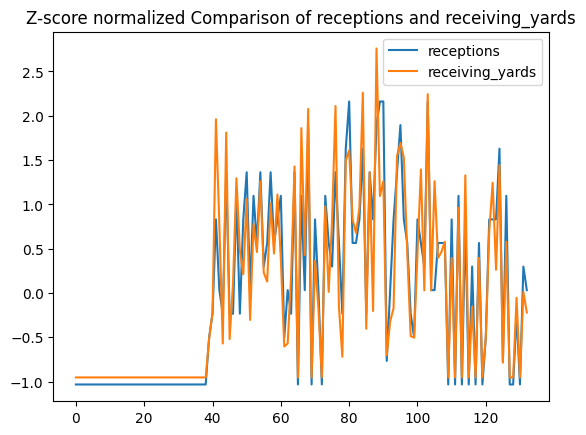

In [259]:
import matplotlib.pyplot as plt

plt.plot(collected_data['var_1'],label = VAR_1)
plt.plot(collected_data['var_2'],label = VAR_2)
plt.legend()
plt.title(f"Z-score normalized Comparison of {VAR_1} and {VAR_2}")

In [260]:
# Next lets do the strategy perform a running mean and then o/u for both bool array then get table
# Later improve this
WINDOW_SIZE = 5
WEIGHT = [0.05,0.05,0.05,0.05,0.8]

collected_data = collected_data.with_columns(
    pl.col('var_1').rolling_mean(WINDOW_SIZE, WEIGHT).alias("var_1_rolling")
)
collected_data = collected_data.with_columns(
    pl.col('var_2').rolling_mean(WINDOW_SIZE,WEIGHT).alias("var_2_rolling")
)

collected_data = collected_data.slice(WINDOW_SIZE-1)

collected_data = collected_data.with_columns(
    (pl.col('var_1')>pl.col('var_1_rolling')).alias('var_1_over')
)

collected_data = collected_data.with_columns(
    (pl.col('var_2')>pl.col('var_2_rolling')).alias('var_2_over')
)

collected_data.head()

var_1,var_2,data_info,var_1_rolling,var_2_rolling,var_1_over,var_2_over
f64,f64,i32,f64,f64,bool,bool
-1.032413,-0.9529,200213,-1.032413,-0.9529,true,false
-1.032413,-0.9529,200214,-1.032413,-0.9529,true,false
-1.032413,-0.9529,200215,-1.032413,-0.9529,true,false
-1.032413,-0.9529,200216,-1.032413,-0.9529,true,false
-1.032413,-0.9529,20047,-1.032413,-0.9529,true,false


In [261]:
p = [[0,0],[0,0]]
p[1][0] = ((collected_data['var_1_over'] & ~collected_data['var_2_over']).sum())/len(collected_data) # over under
p[1][1] = ((collected_data['var_1_over'] & collected_data['var_2_over']).sum())/len(collected_data) # over over
p[0][1] = ((~collected_data['var_1_over'] & collected_data['var_2_over']).sum())/len(collected_data) # under over
p[0][0] = ((~collected_data['var_1_over'] & ~collected_data['var_2_over']).sum())/len(collected_data) # under under

In [277]:
print(p)

[[0.3178294573643411, 0.03875968992248062], [0.3178294573643411, 0.32558139534883723]]


In [281]:
# EV Calc

VAR_1_OVER = True
VAR_2_OVER = False
PARLAY_BET_1 = 15
PARLAY_BET_2 = 5
MULTIPLIER = 2.5
OTHER_BETS_PROB = 0.75

# If both bets win
ev = ((MULTIPLIER-1)*PARLAY_BET_1+(MULTIPLIER-1)*PARLAY_BET_2)*(p[VAR_1_OVER][VAR_2_OVER]*OTHER_BETS_PROB)

# if just var 1 parlay wins
ev += ((MULTIPLIER-1)*PARLAY_BET_1-PARLAY_BET_2)*(p[VAR_1_OVER][not VAR_2_OVER]*OTHER_BETS_PROB)

# if just var 2 parlay wins
ev += ((MULTIPLIER-1)*PARLAY_BET_2-PARLAY_BET_1)*(p[not VAR_1_OVER][VAR_2_OVER]*OTHER_BETS_PROB)

# if both lose
ev += (0-PARLAY_BET_2-PARLAY_BET_1)*(p[not VAR_1_OVER][not VAR_2_OVER]+1-OTHER_BETS_PROB-(p[not VAR_1_OVER][not VAR_2_OVER]*(1-OTHER_BETS_PROB)))

print(f"EV: {ev}")

EV: 4.055232558139533


In [282]:
pnl = [10]
assets = [20,30]